In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from datasets.ner_dataset import get_ner_dataset, NerDataset

In [4]:
def plot_class_distribution(data: NerDataset, title: str) -> pd.DataFrame:
    token_list = []
    for i in range(len(data)):
        token_list.extend(list(map(lambda x: (x[0].item(), data.index2label[x[1].item()]), 
                                   zip(*data[i][1:]))))
    token_list = list(filter(lambda x: x[   1].strip() != '[PAD]', token_list))
    print(f"The number of all tokens: {len(token_list)}")
    df = pd.DataFrame(token_list, columns=['token','label'])
    print(df['label'].value_counts(normalize = False))
    distr = df['label'].loc[df['label'] != 'O'].value_counts(normalize = True)
    plt.figure(figsize=(15, 2.5))
    with sns.plotting_context("talk", font_scale=0.5), sns.axes_style('whitegrid'), sns.mpl_palette("GnBu_d", n_colors=len(distr)):
        sns.barplot(x=distr.index, y=distr.values).set_title(title)
    return df

In [5]:
def plot_len_distribution(data: NerDataset):
    len_list = [len(data[i][1]) for i in range(len(data))]
    print(f"The number of records: {len(len_list)}")
    df = pd.DataFrame({'length': len_list})
    print(f"The mean length: {df['length'].mean()}")
    plt.figure(figsize=(16, 8))
    with sns.plotting_context("talk", font_scale=0.7), sns.axes_style('whitegrid'), sns.mpl_palette("GnBu_d"):
        sns.histplot(df['length'], kde=False, bins=50).set_title("Распределение количества токенов в записях")

### Этап 5: Дополнительное исследование данных

Анализ данных будет проходить на онснове токенизатора основной модели "bert-large-uncased".

#### i2b2 2014

In [6]:
data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)
data_config['eq_max_padding'] = False
data_config['max_length'] = None
train_dataset = get_ner_dataset(path_to_folder=data_config["train_data_path"], device="cpu", **data_config)
val_dataset = get_ner_dataset(path_to_folder=data_config["validate_data_path"], device="cpu", **data_config)

Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


The number of all tokens: 867414
label
O             805777
DATE           33592
NAME           12814
LOCATION        7116
ID              4769
CONTACT         1514
AGE             1320
PROFESSION       512
Name: count, dtype: int64


/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


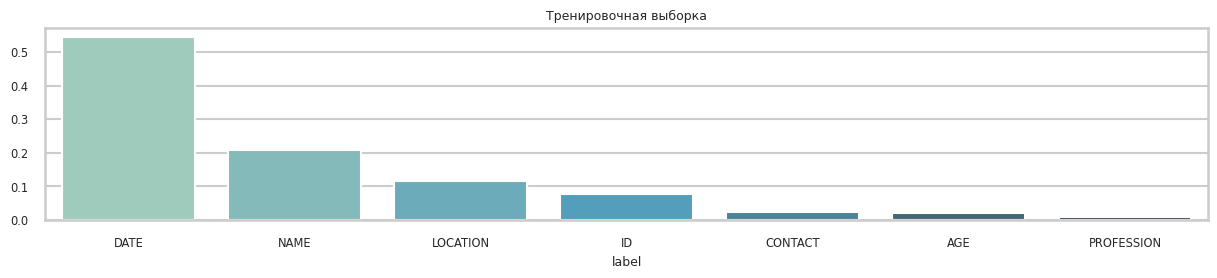

In [7]:
train_df = plot_class_distribution(train_dataset, 'Тренировочная выборка')

The number of all tokens: 558061
label
O             517695
DATE           21905
NAME            8107
LOCATION        4522
ID              3452
CONTACT         1147
AGE              827
PROFESSION       406
Name: count, dtype: int64


/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


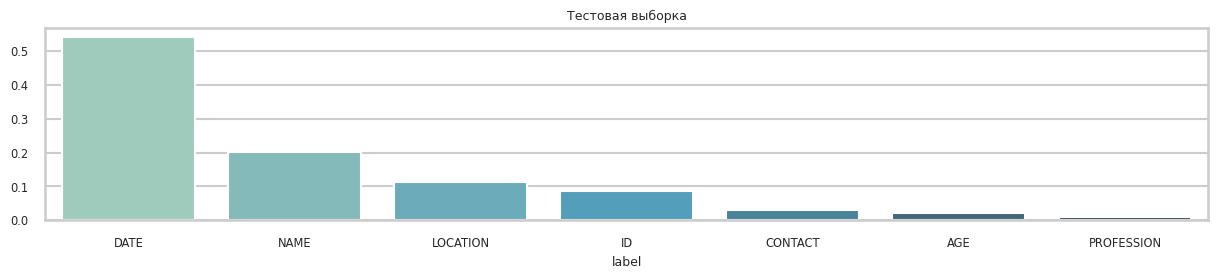

In [8]:
val_df = plot_class_distribution(val_dataset, 'Тестовая выборка')

Заметим, что около $90\%$  токенов являются 'OTHER' и распозоваемые сущности занимают менее 10% всего текста, т.к одна четверть токенов являются техническими. Распознаваемые классы распределены неравномерно. Среди них самым популярным является класс 'DATE', оставшиеся классы встречаются в два раза реже. А самым редким классом, который определён только у 830 токенов, является 'PROFESSION', что приводит к относительно низкому качеству его распозавания всеми моделями.  
Распределение классов в тренировочной и валидационной выборке совпадает. При этом обучающая выборка лишь в полтора раза больше тестовой.

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


The number of records: 790
The mean length: 1099.9924050632912


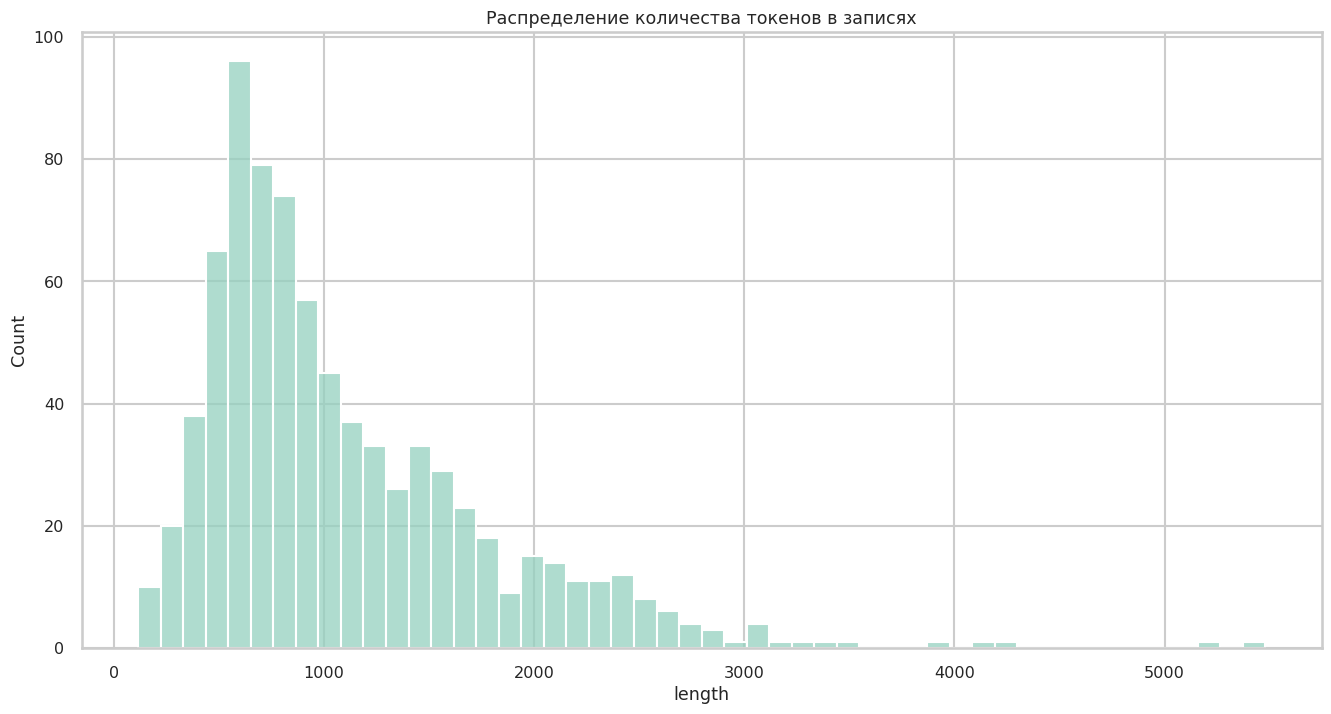

In [9]:
plot_len_distribution(train_dataset)

The number of records: 514
The mean length: 1087.7217898832685


/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


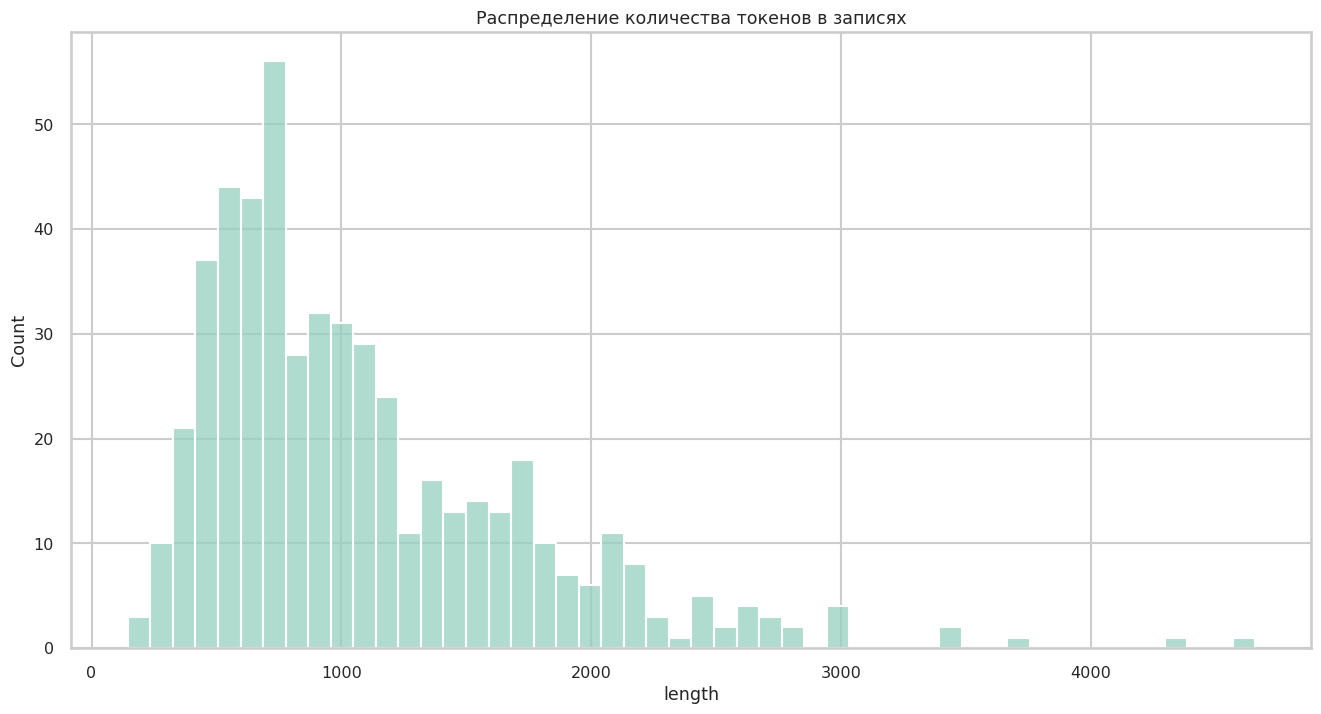

In [10]:
plot_len_distribution(val_dataset)

Распределение длин одинаково для тренировочной и валидационной выборок и схоже с колоколом распределения Пуассона.  
Примечательно, что средняя длина в обоих наборах данных почти совпадает.

#### i2b2 2006

In [11]:
data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
data_config['eq_max_padding'] = False
data_config['max_length'] = None
train_dataset = get_ner_dataset(path_to_folder=data_config["train_data_path"], device="cpu", **data_config)
val_dataset = get_ner_dataset(path_to_folder=data_config["validate_data_path"], device="cpu", **data_config)

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


The number of all tokens: 562790
label
O           502149
NAME         20089
ID           17054
DATE         14502
LOCATION      7643
CONTACT       1316
AGE             37
Name: count, dtype: int64


/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


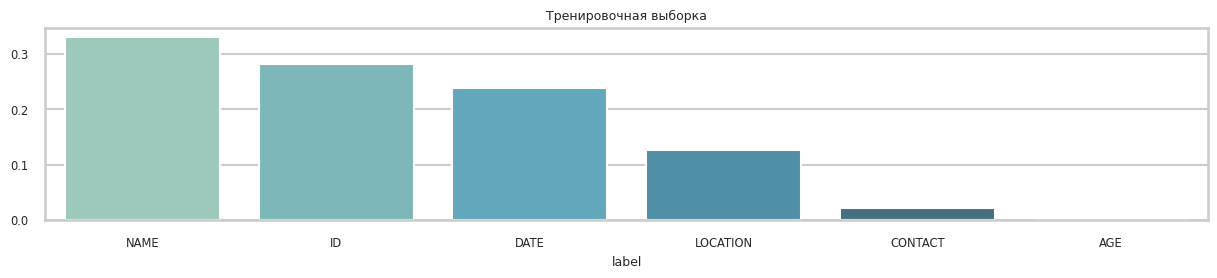

In [12]:
train_df = plot_class_distribution(train_dataset, 'Тренировочная выборка')

The number of all tokens: 232780
label
O           211506
NAME          6610
ID            5361
DATE          5224
LOCATION      3664
CONTACT        409
AGE              6
Name: count, dtype: int64


/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


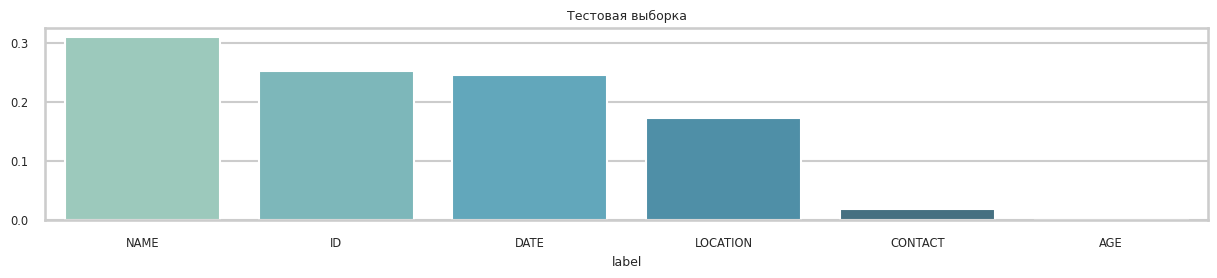

In [13]:
val_df = plot_class_distribution(val_dataset, 'Тестовая выборка')

Заметим, что около $90\%$  токенов являются 'OTHER' и распозоваемые сущности занимают менее 10% всего текста, т.к одна пятая токенов являются техническими. Распознаваемые классы распределены более равномерно, чем в наборе данных за 2014 год, однако в нём отсутствует класс 'PROFESSION' и почти не представлен класс 'AGE' (51 токен). Среди присутсвующих самым популярным является класс 'NAME' --- $25\%$ токенов сущностей, оставшиеся классы занимают $<21\%$. А самым редким классом, который определён только у 714 токенов, является 'CONTACT', занимая лишь $~2\%$ токенов.  
Распределение классов в тренировочной и валидационной выборке совпадает. При этом обучающая выборка примерно в три раза больше тестовой.

The number of records: 669
The mean length: 843.2406576980568


/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


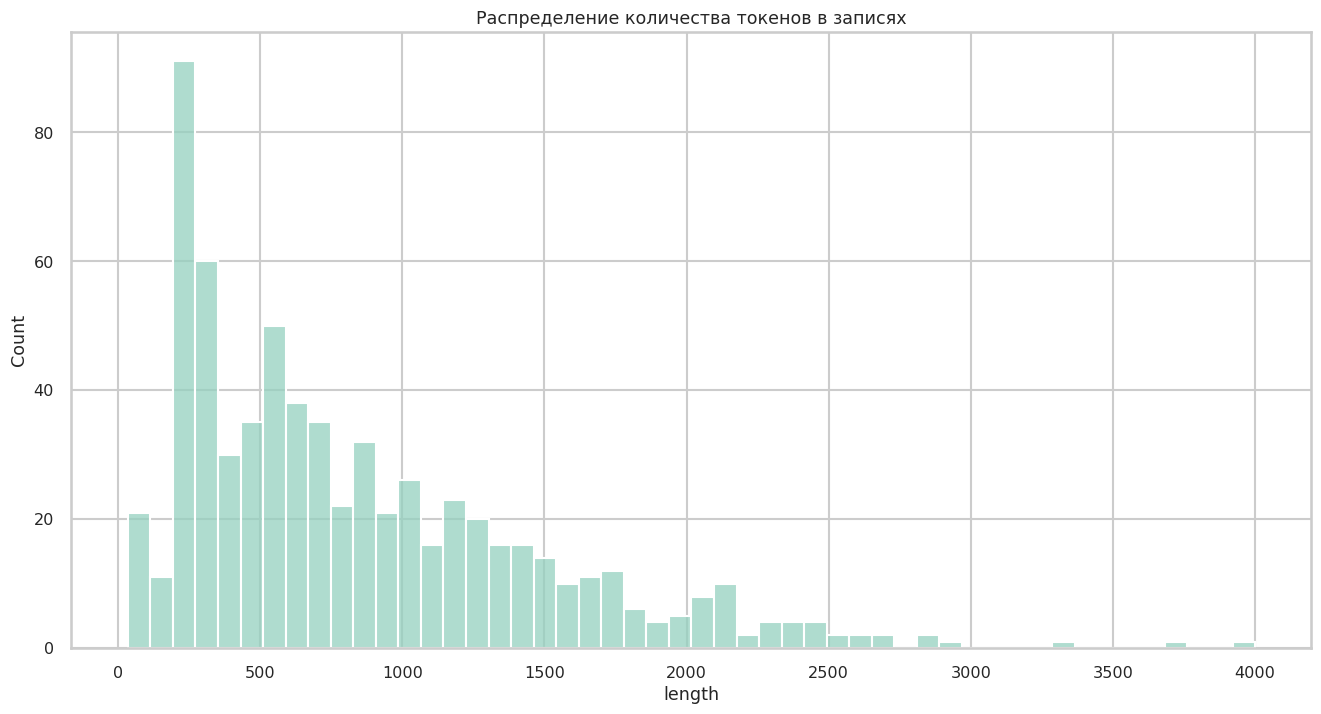

In [14]:
plot_len_distribution(train_dataset)

The number of records: 220
The mean length: 1060.090909090909


/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


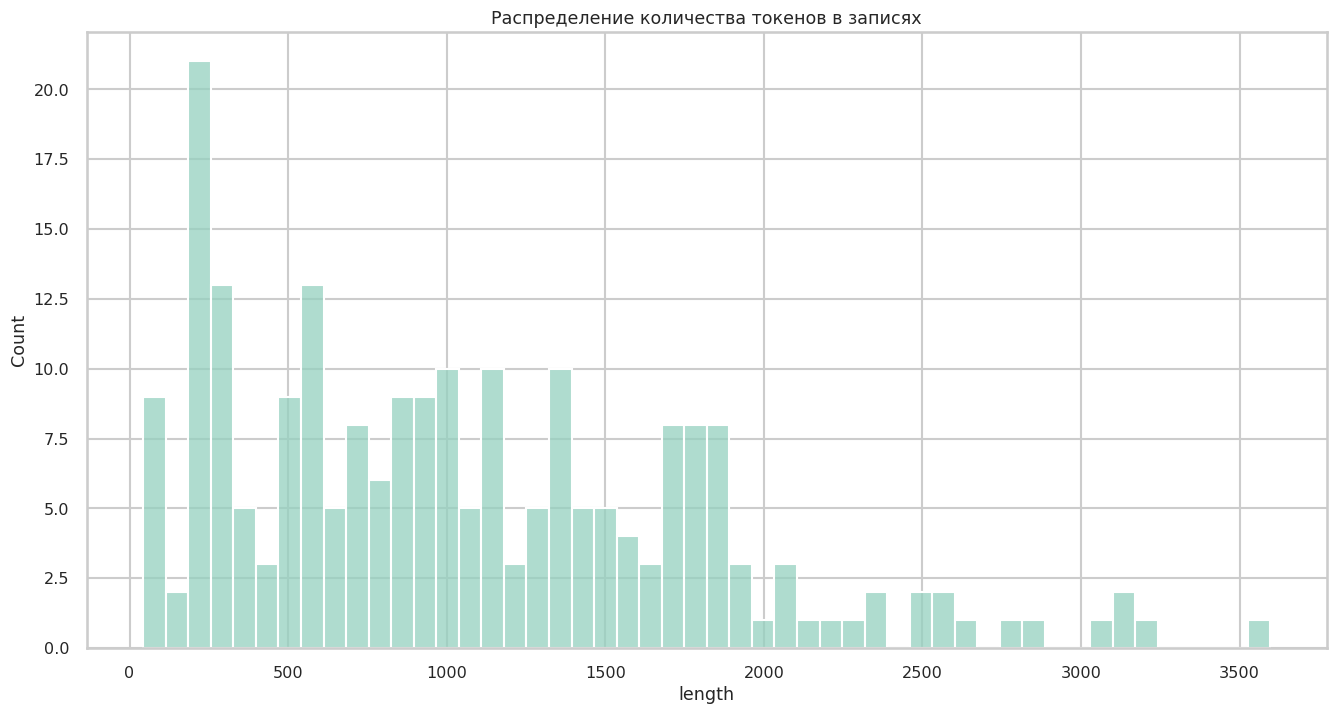

In [15]:
plot_len_distribution(val_dataset)

Распределение длин текстов в тренировочной и тестовой выборках несколько отличается: если в первой наблюдаются очертания колокола Пуассоновского распределения, то во второй распределение более пологое и ближе к равномерному.  
Стоит отметить, что средняя длина валидационных текстов на 200 токенов больше аналогичной у тренировочных.